In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from time import time
import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.layers import Dense,GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras import backend as K

%matplotlib inline
print(tf.keras.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


2.1.6-tf
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
# Input constants
HEIGHT = 65
WIDTH = 62
CHANNELS = 3
NUM_CLASSES = 60
NUM_TRAIN_IMAGES = 660

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, CHANNELS))

C:\Users\Laurenz\Anaconda3\envs\tfgpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [3]:
# Data Generator constants
TRAIN_DIR = "simple_clock/Datagenerator_simple_clock/Training"
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=1,
                                    #horizontal_flip=False,
                                    #vertical_flip=False,
                                    width_shift_range=0.03,
                                    height_shift_range=0.03,
                                    shear_range=0.01,
                                    zoom_range=0.03,
                                    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size=(HEIGHT, WIDTH),
                                                    batch_size=BATCH_SIZE)

Found 660 images belonging to 60 classes.


In [4]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='sigmoid')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [5]:
# Top Layer constants
FC_LAYERS = [128,128,128, 128]
DROPOUT = 0.1

finetune_model = build_finetune_model(base_model, 
                                      dropout=DROPOUT, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=NUM_CLASSES)

#finetune_model.summary()

Found 60 images belonging to 60 classes.
Img1 - real: 0, pred: 210
Img2 - real: 6, pred: 48
Img3 - real: 12, pred: 48


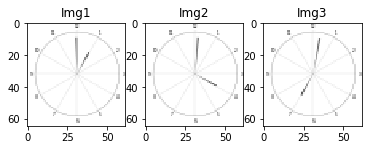

In [6]:
#Testing the model
TEST_DIR = "simple_clock/Datagenerator_simple_clock/Testing"

IMG_PATH_1 = "simple_clock/Datagenerator_simple_clock/Testing/0/clock-01.00.00.PNG"
IMG_PATH_2 = "simple_clock/Datagenerator_simple_clock/Testing/6/clock-04.01.00.PNG"
IMG_PATH_3 = "simple_clock/Datagenerator_simple_clock/Testing/12/clock-07.02.00.PNG"

test_datagen =  ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                 target_size=(HEIGHT, WIDTH),
                                                 batch_size=1,
                                                 class_mode=None,  # only data, no labels
                                                 shuffle=False
                                                )  

preds = finetune_model.predict_generator(test_generator, 60)

#visualizing some examples
fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img1') 
a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_2), cmap='gray', vmin=0, vmax=1)
a.set_title('Img2') 
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_3), cmap='gray', vmin=0, vmax=1)
a.set_title('Img3') 
print("Img1 - real: 0, pred: %d" % (np.argmax(preds[0], axis=0)*6))
print("Img2 - real: 6, pred: %d" % (np.argmax(preds[1], axis=0)*6))
print("Img3 - real: 12, pred: %d" % (np.argmax(preds[2], axis=0)*6))

In [ ]:
# Model loading
FILEPATH_LOAD = "./checkpoints/ResNet50_model_weights.h5"
LOAD_WHOLE_MODEL = FALSE

if (LOAD_WHOLE_MODEL):
    finetune_model = keras.models.load_model(FILEPATH_LOAD)
else:
    finetune_model.load_weights(FILEPATH_LOAD)

In [7]:
# Training constants
NUM_EPOCHS = 75
LEARNING_RATE = 0.0009

FILEPATH_SAVE='checkpoints/ResNet50_{}_model_weights.h5'.format(time())
FILEPATH_TENSORBOARD_LOG = 'logdir/{}'.format(int(time()))

checkpoint = ModelCheckpoint(FILEPATH_SAVE,
                             monitor=["acc"],
                             verbose=1,
                             mode='max'
                            )
                                               
early_stopping = EarlyStopping(monitor='acc',
                               min_delta=0.002,
                               patience=4,
                               verbose=0,
                               mode='auto',
                               restore_best_weights=True)
                                               
tensorboard = TensorBoard(log_dir = FILEPATH_TENSORBOARD_LOG)

callbacks_list = [tensorboard]

adam = Adam(lr=LEARNING_RATE)

finetune_model.compile(adam,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

history = finetune_model.fit_generator(train_generator, 
                                       epochs=NUM_EPOCHS,
                                       workers=8, 
                                       steps_per_epoch=NUM_TRAIN_IMAGES // BATCH_SIZE, 
                                       shuffle=True,
                                       callbacks=callbacks_list
                                      )

Epoch 1/75
82/82 [==============================] - 9s 105ms/step - loss: 4.1671 - acc: 0.0076
Epoch 2/75
82/82 [==============================] - 4s 44ms/step - loss: 3.9854 - acc: 0.0229
Epoch 3/75
82/82 [==============================] - 3s 42ms/step - loss: 3.6769 - acc: 0.0595
Epoch 4/75
82/82 [==============================] - 3s 42ms/step - loss: 3.2774 - acc: 0.0762
Epoch 5/75
82/82 [==============================] - 4s 46ms/step - loss: 3.1990 - acc: 0.0747
Epoch 6/75
82/82 [==============================] - 4s 43ms/step - loss: 3.0412 - acc: 0.1113
Epoch 7/75
82/82 [==============================] - 4s 46ms/step - loss: 2.8491 - acc: 0.1128
Epoch 8/75
82/82 [==============================] - 4s 45ms/step - loss: 2.7336 - acc: 0.0976
Epoch 9/75
82/82 [==============================] - 4s 44ms/step - loss: 2.6025 - acc: 0.1326
Epoch 10/75
82/82 [==============================] - 4s 44ms/step - loss: 2.6513 - acc: 0.1585
Epoch 11/75
82/82 [==============================] - 4s 44

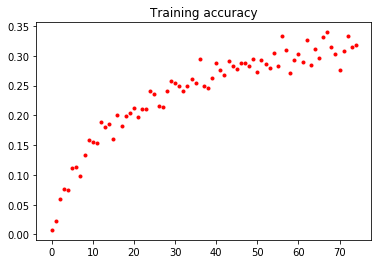

In [8]:
#Plotting constants
PLOT_PATH = 'acc_vs_epochs_resnet50_24_4_19_128_128_128_128.png'

acc = history.history['acc']
loss = history.history['loss']
epochs = range(len(acc))

plt.plot(epochs, acc, 'r.')
plt.title('Training accuracy')

plt.savefig(PLOT_PATH)
plt.show()   

Img1 - real: 0, pred: 39
Img2 - real: 6, pred: 49
Img3 - real: 12, pred: 49


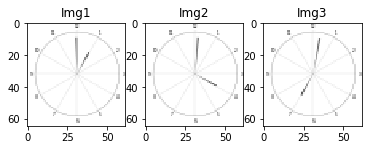

In [9]:
# Testing the model again
preds = finetune_model.predict_generator(test_generator, 60)

#visualizing some examples
fig = plt.figure()
a = fig.add_subplot(1, 3, 1)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_1), cmap='gray', vmin=0, vmax=1)
a.set_title('Img1') 
a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_2), cmap='gray', vmin=0, vmax=1)
a.set_title('Img2') 
a = fig.add_subplot(1, 3, 3)
imgplot = plt.imshow(mpimg.imread(IMG_PATH_3), cmap='gray', vmin=0, vmax=1)
a.set_title('Img3') 
print("Img1 - real: 0, pred: %d" % (np.argmax(preds[0], axis=0)))
print("Img2 - real: 6, pred: %d" % (np.argmax(preds[1], axis=0)))
print("Img3 - real: 12, pred: %d" % (np.argmax(preds[2], axis=0)))

In [ ]:
# saving Model
FILEPATH_SAVE = "./checkpoints/ResNet50_model_weights.h5"
SAVE_WHOLE_MODEL = FALSE

if (SAVE_WHOLE_MODEL):
    finetune_model.save(FILEPATH_SAVE)
else:
    finetune_model.save_weights(FILEPATH_SAVE)